In [1]:
import sys, os, time, shutil, random
from pathlib import Path
if '_cwd' not in locals():
    _cwd = os.getcwd()
    os.chdir(Path(_cwd)/'..')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

%load_ext autoreload
%autoreload 2

import numpy as np
np.set_printoptions(linewidth=120)
import pickle
from tabulate import tabulate
from tqdm.notebook import tqdm
import torch
from torch import nn, optim as opt
import torch.nn.functional as F
import torch.distributions as distrib
from torch.utils.data import Dataset, DataLoader, TensorDataset

%matplotlib notebook
import matplotlib.pyplot as plt

from src.helix import helix_labels, helix_observations, ToyVAE

2022-05-25 13:41:37.428495: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /is/ei/fleeb/miniconda3/lib/python3.8/site-packages/cv2/../../lib64:/is/ei/fleeb/.mujoco/mujoco200/bin
2022-05-25 13:41:37.428511: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [22]:
# Dataset Hyperparameters
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_training_samples = 1024
nhelix = 2
gen = torch.Generator().manual_seed(67280421310721)

In [23]:
Y = helix_labels(num_training_samples, strands=nhelix, gen=gen).to(device)
X = helix_observations(Y, w=1., Rx=1., Ry=1., Rz=1.)
Y.shape, X.shape

(torch.Size([1024, 2]), torch.Size([1024, 3]))

<IPython.core.display.Javascript object>


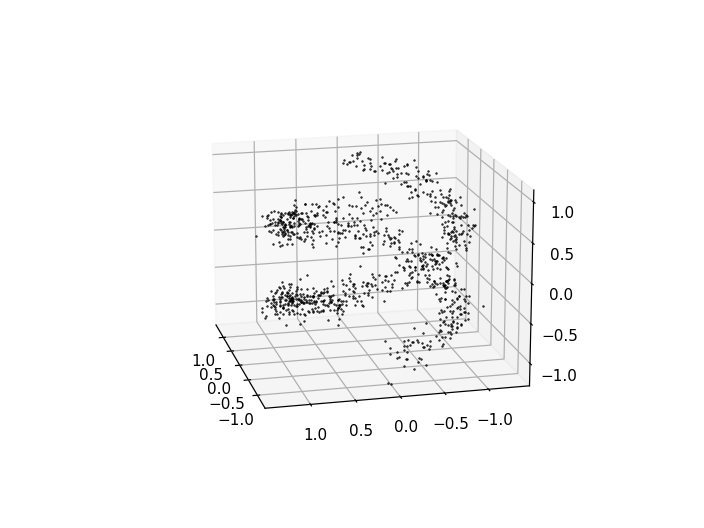

In [26]:
plt.figure()
data_ax = plt.axes(projection='3d')
plt.plot(*X.cpu().t(), ls='', marker='.', c='k', ms=1, );

In [315]:
# Model Hyperparameters
budget = 5000
batch_size = 128

latent_dim = 2


beta = 0.05
hidden_dims = [32, 32, 32, 32]
nonlin = nn.ELU

optim_type = opt.Adam
lr = 0.01

In [316]:
model = ToyVAE(obs_dim=X.size(1), latent_dim=2, beta=beta, hidden=hidden_dims, nonlin=nonlin)
model.to(device)
optimizer = optim_type(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, amsgrad=True,)
print(model)

ToyVAE(
  (encoder): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ELU(alpha=1.0)
    (8): Linear(in_features=32, out_features=4, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ELU(alpha=1.0)
    (8): Linear(in_features=32, out_features=3, bias=True)
  )
  (criterion): MSELoss()
)


In [317]:
dataloader = DataLoader(TensorDataset(X), batch_size=batch_size, shuffle=True)
loader = iter([])
losses = []

In [318]:
model.train()
itr = tqdm(range(budget))
if len(losses):
    itr.set_description(f'{losses[-1]:.3f}')
for i in itr:
    try:
        batch = next(loader)
    except StopIteration:
        loader = iter(dataloader)
        batch = next(loader)
    
    x, = batch
    x = x.to(device)
    loss, info = model(x)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(info['rec_loss'].mean().item())
    itr.set_description(f'{np.mean(losses[-100:]):.3f}')

  0%|          | 0/5000 [00:00<?, ?it/s]

In [327]:
# plt.figure()
# plt.plot(losses);

In [320]:
model.eval()
with torch.no_grad():
    Z = model.encode(X)
    S = Z.mean
    rec = model.decode(S)

<IPython.core.display.Javascript object>


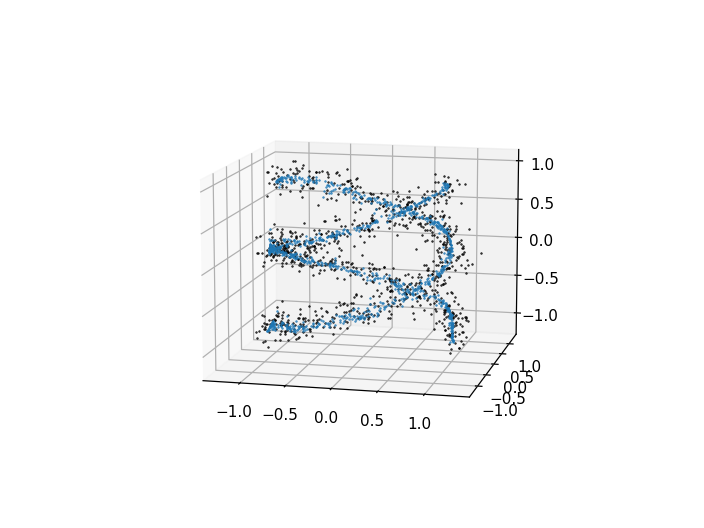

In [321]:
plt.figure()
plt.axes(projection='3d')
plt.plot(*X.cpu().t(), ls='', marker='.', c='k', ms=1, );
plt.plot(*rec.cpu().t(), ls='', marker='.', c='C0', ms=1, );

In [322]:
def get_divergence(deltas):
    divx, divy = np.gradient(deltas, axis=[0,1])
    divM = divx[...,0] + divy[...,1]
    return torch.from_numpy(divM)

In [323]:
rg = 2

mn, mx = S.min(0)[0], S.max(0)[0]
mn, mx = torch.ones(2)*-rg, torch.ones(2)*rg
mn, mx

(tensor([-2., -2.]), tensor([2., 2.]))

In [324]:
n = 150
h, w = n, n

xvals, yvals = torch.linspace(mn[0].item(),mx[0].item(),h), torch.linspace(mn[1].item(),mx[1].item(),w)
# xvals, yvals = torch.linspace(-rg,rg,h), torch.linspace(-rg,rg,w)
cx, cy = torch.meshgrid(xvals, yvals)
cx = cx.reshape(-1)
cy = cy.reshape(-1)

starts = torch.stack([cx,cy],-1)
with torch.no_grad():
    ends = model.response(starts.to(device))
    if isinstance(ends, distrib.Distribution):
        ends = ends.mean
    ends = ends.cpu()
starts = starts.view(h,w,-1)
ends = ends.view(h,w,-1)
deltas = ends - starts
deltas.shape

torch.Size([150, 150, 2])

In [325]:
magmap = deltas.norm(dim=-1)
divmap = get_divergence(deltas)
sdivmap = divmap.clone()
if sdivmap.min() < 0:
    sdivmap[sdivmap<0] /= sdivmap.min().abs()
else:
    print('WARNING: min')
if sdivmap.max() > 0:
    sdivmap[sdivmap>0] /= sdivmap.max().abs()
else:
    print('WARNING: max')

curvmap = -0.5*get_divergence(deltas.div(magmap.unsqueeze(-1)))
happymap = divmap<0

<IPython.core.display.Javascript object>


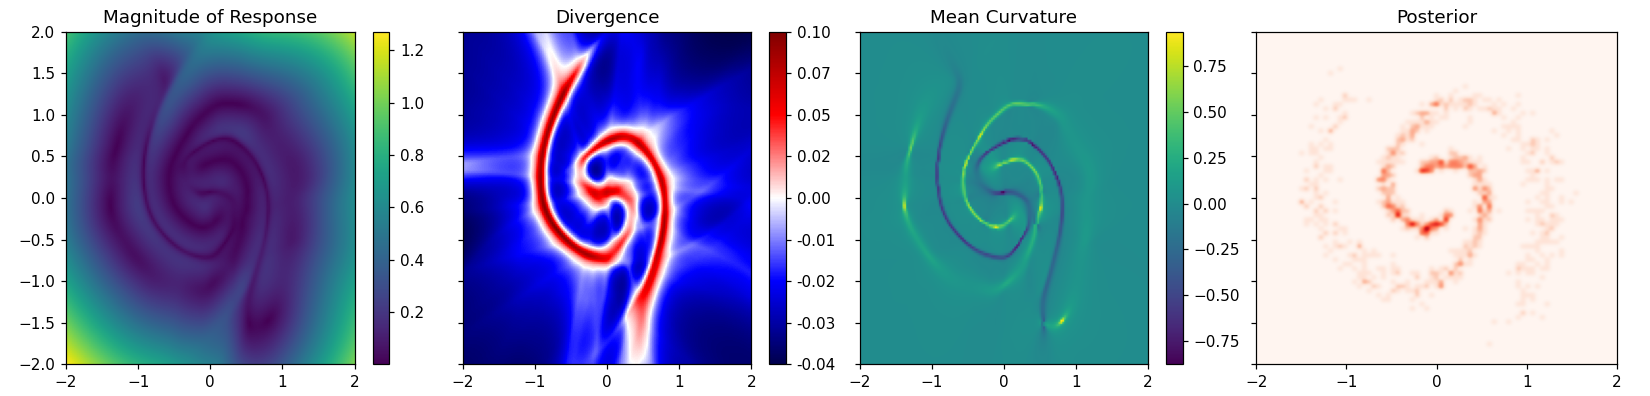

In [326]:
im_kwargs = dict(
    aspect = 'auto',
    extent=[xvals.min(),xvals.max(),yvals.min(),yvals.max()],
)

fg, axs = plt.subplots(1,4, figsize=(15,3.6),sharex=True, sharey=True)

plt.sca(axs[0])
plt.title('Magnitude of Response')
plt.imshow(magmap.numpy().T[::-1], cmap='viridis', **im_kwargs);
plt.colorbar()

plt.sca(axs[1])
plt.title('Divergence')
plt.imshow(sdivmap.numpy().T[::-1], cmap='seismic', **im_kwargs);
cbar = plt.colorbar()
axvals = np.concatenate([np.linspace(divmap.min().item(), 0,5), np.linspace(0,divmap.max().item(),5)[1:]])
axlbls = [f'{v.item():.2f}' for v in axvals]
cbar.set_ticks(np.linspace(-1, 1,9))
cbar.set_ticklabels(axlbls)

plt.sca(axs[2])
plt.title('Mean Curvature')
plt.imshow(curvmap.numpy().T[::-1], cmap='viridis', **im_kwargs);
plt.colorbar()

plt.sca(axs[3])
plt.title('Posterior')
plt.xlim(xvals.min(),xvals.max(),)
plt.ylim(yvals.min(),yvals.max())
hist, *other = np.histogram2d(*S.t().cpu().numpy(), bins=n//2, normed=True, range=torch.stack([mn,mx]).t().cpu().numpy())
plt.imshow(hist.T[::-1], cmap='Reds', interpolation = "gaussian", **im_kwargs)
# sns.kdeplot(*Q.t().cpu().numpy(), shade=True, ax=axs[3], gridsize=200, thresh=0.01)
badsel = np.ones((*happymap.shape,4))
badsel[...,-1] = 0.
badsel[~happymap.numpy().T[::-1]] = [1,0,0,1]
# plt.imshow(badsel, alpha=0.3, **im_kwargs)
# plt.imshow(mags);
# plt.tight_layout()
e = 0.08
plt.subplots_adjust(0.04,0.08,1-.02,1-0.08,0.1,0);
# util.save_figure('helix-maps', **fig_kwargs)